Total windows: 176 Feature dimension: 45
Class counts: {np.str_('bicep'): np.int64(74), np.str_('jump'): np.int64(15), np.str_('overheadpress'): np.int64(28), np.str_('squat'): np.int64(33), np.str_('tricep'): np.int64(26)}
Split sizes: 105 35 36
Best max_depth (by val log loss): 4

=== Test Metrics (Macro Avg) ===
Accuracy : 1.0
Precision: 1.0
Recall   : 1.0
F1-score : 1.0
Log Loss : 2.2204460492503136e-16

Confusion matrix (rows=true, cols=pred), labels = [np.str_('bicep'), np.str_('jump'), np.str_('overheadpress'), np.str_('squat'), np.str_('tricep')]
[[15  0  0  0  0]
 [ 0  3  0  0  0]
 [ 0  0  6  0  0]
 [ 0  0  0  7  0]
 [ 0  0  0  0  5]]


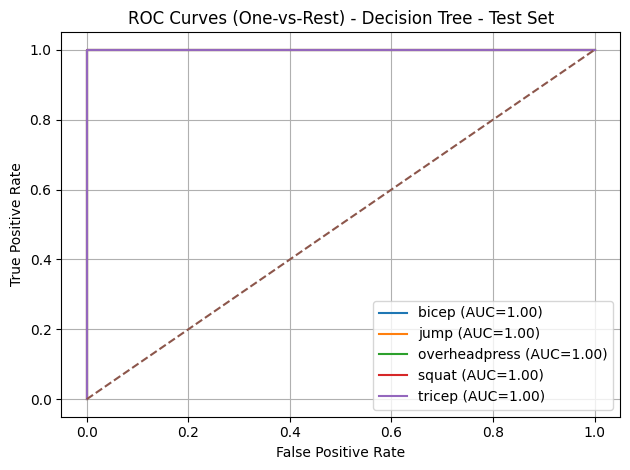

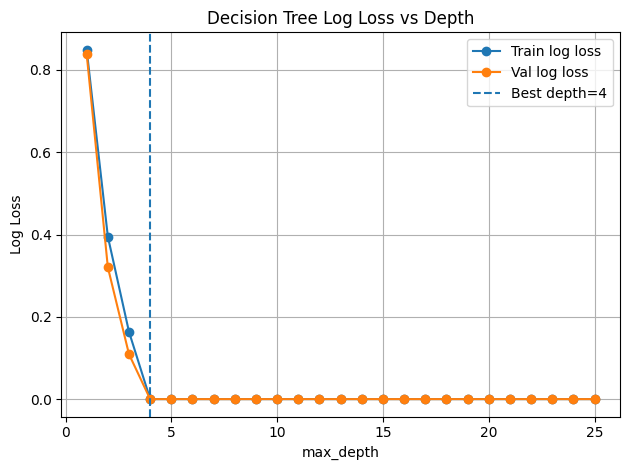

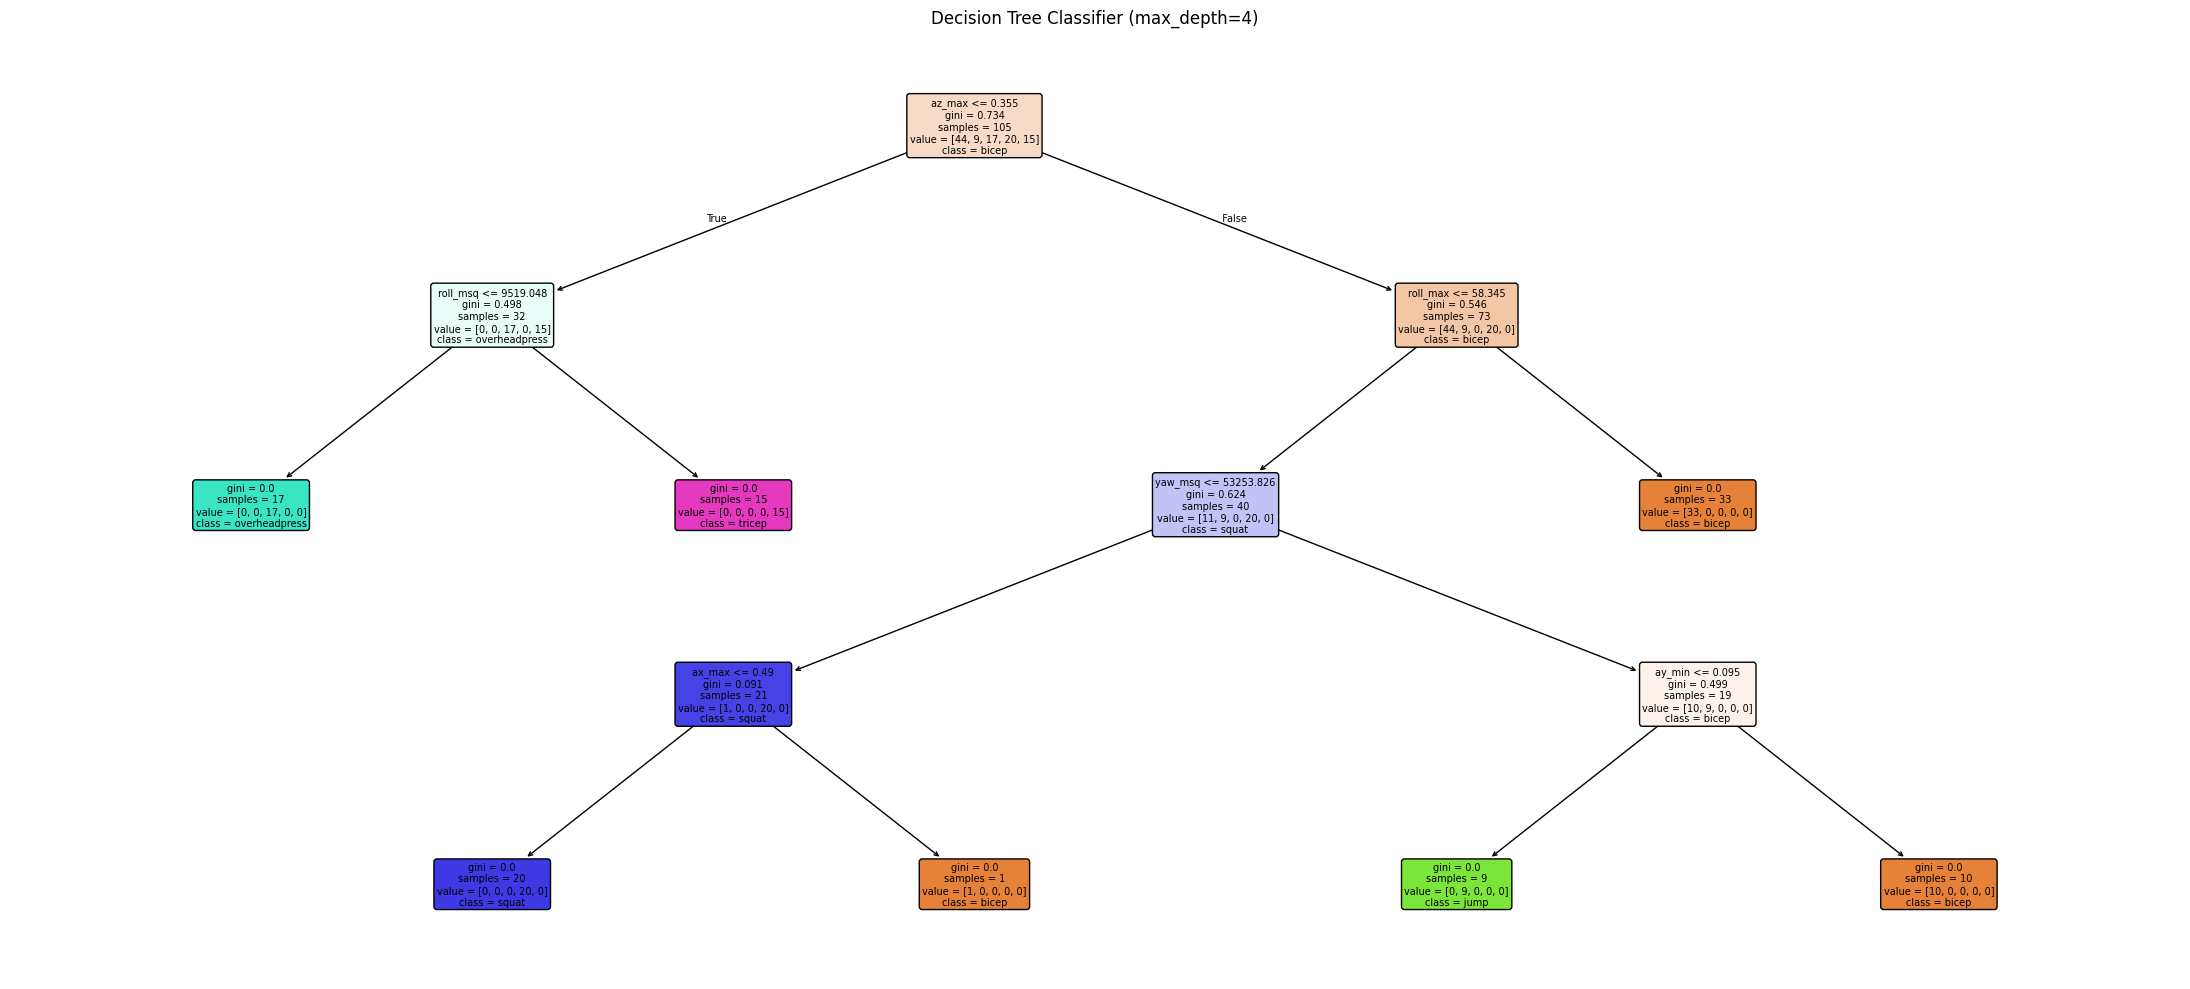


Saved figures:
  roc_auc_dt_test.png
  logloss_dt_vs_depth.png
  decision_tree_dt.png


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    precision_score, recall_score, accuracy_score, f1_score,
    confusion_matrix, roc_curve, auc, log_loss
)
from sklearn.preprocessing import label_binarize

# ----------------------------
# 1) File paths for 5 classes
# ----------------------------
paths = {
    'bicep': 'imu_bicep_m0.csv',
    'tricep': 'imu_tricep_m1.csv',
    'overheadpress': 'imu_overheadpress_m2.csv',
    'jump': 'imu_jump_m3.csv',
    'squat': 'imu_squat_m4.csv'
}

# CSVs have no header row; enforce column names:
colnames = ["timestamp","ax","ay","az","gx","gy","gz","roll","pitch","yaw"]
channels = ["ax","ay","az","gx","gy","gz","roll","pitch","yaw"]

dfs = {label: pd.read_csv(p, header=None, names=colnames) for label, p in paths.items()}

# ----------------------------
# 2) Windowing (100 Hz IMU)
# ----------------------------
FS = 100
WIN = 100      # 1 second window
STRIDE = 50    # 0.5 second overlap

def window_featurize(df, label, win=WIN, stride=STRIDE):
    """
    Convert a time-series file into windowed feature vectors.
    Features per channel: mean, std, min, max, mean-square (energy proxy)
    """
    X, y = [], []
    for start in range(0, len(df) - win + 1, stride):
        w = df.iloc[start:start+win]
        feats = []
        for c in channels:
            x = w[c].astype(float).to_numpy()
            feats.extend([
                x.mean(),
                x.std(ddof=0),
                x.min(),
                x.max(),
                np.mean(x**2)
            ])
        X.append(feats)
        y.append(label)
    return np.array(X, dtype=np.float32), np.array(y)

X_list, y_list = [], []
for label, df in dfs.items():
    Xw, yw = window_featurize(df, label)
    X_list.append(Xw)
    y_list.append(yw)

X = np.vstack(X_list)
y = np.concatenate(y_list)

feature_names = [f"{c}_{stat}" for c in channels for stat in ["mean","std","min","max","msq"]]

print("Total windows:", X.shape[0], "Feature dimension:", X.shape[1])
print("Class counts:", dict(zip(*np.unique(y, return_counts=True))))

# ----------------------------
# 3) Split 60/20/20
# ----------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Split sizes:", len(y_train), len(y_val), len(y_test))

# ----------------------------
# 4) Tune max_depth by validation log-loss
# ----------------------------
depths = list(range(1, 26))
train_ll, val_ll = [], []

for d in depths:
    clf_d = DecisionTreeClassifier(max_depth=d, random_state=42)
    clf_d.fit(X_train, y_train)
    train_ll.append(log_loss(y_train, clf_d.predict_proba(X_train), labels=clf_d.classes_))
    val_ll.append(log_loss(y_val, clf_d.predict_proba(X_val), labels=clf_d.classes_))

best_depth = depths[int(np.argmin(val_ll))]
print("Best max_depth (by val log loss):", best_depth)

clf = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
clf.fit(X_train, y_train)

# ----------------------------
# 5) Test metrics
# ----------------------------
y_pred = clf.predict(X_test)
proba = clf.predict_proba(X_test)
labels = list(clf.classes_)

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
rec  = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1   = f1_score(y_test, y_pred, average="macro", zero_division=0)
ll   = log_loss(y_test, proba, labels=labels)

print("\n=== Test Metrics (Macro Avg) ===")
print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1-score :", f1)
print("Log Loss :", ll)

cm = confusion_matrix(y_test, y_pred, labels=labels)
print("\nConfusion matrix (rows=true, cols=pred), labels =", labels)
print(cm)

# ----------------------------
# 6) Save visuals (must include '_dt_')
# ----------------------------
out_dir = ""
roc_path  = os.path.join(out_dir, "roc_auc_dt_test.png")
ll_path   = os.path.join(out_dir, "logloss_dt_vs_depth.png")
tree_path = os.path.join(out_dir, "decision_tree_dt.png")

# ROC-AUC curves (multiclass one-vs-rest)
y_test_bin = label_binarize(y_test, classes=labels)

plt.figure()
for i, lab in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{lab} (AUC={roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest) - Decision Tree - Test Set")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(roc_path, dpi=200)
plt.show()

# Log loss vs depth curve (train vs val)
plt.figure()
plt.plot(depths, train_ll, marker="o", label="Train log loss")
plt.plot(depths, val_ll, marker="o", label="Val log loss")
plt.axvline(best_depth, linestyle="--", label=f"Best depth={best_depth}")
plt.xlabel("max_depth")
plt.ylabel("Log Loss")
plt.title("Decision Tree Log Loss vs Depth")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(ll_path, dpi=200)
plt.show()

# Decision Tree visualization
plt.figure(figsize=(22, 10))
plot_tree(
    clf,
    feature_names=feature_names,
    class_names=labels,
    filled=True,
    rounded=True,
    fontsize=7,
    max_depth=min(best_depth, 4)   # display only top levels so it stays readable
)
plt.title(f"Decision Tree Classifier (max_depth={best_depth})")
plt.tight_layout()
plt.savefig(tree_path, dpi=200)
plt.show()

print("\nSaved figures:")
print(" ", roc_path)
print(" ", ll_path)
print(" ", tree_path)